In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import pandas as pd
sys.path.append('../')
import spikeoutputs as so
import spikeplots as sp
import celltype_io as ctio
import importlib

In [3]:
ls_experiments = [os.path.basename(f) for f in glob.glob('/Volumes/Vyom MEA/analysis/*') if os.path.isdir(f)]
ls_experiments.sort()

In [4]:
ls_classifications = []
for str_experiment in ls_experiments:
    ls_chunks = [os.path.basename(f) for f in glob.glob(f'/Volumes/Vyom MEA/analysis/{str_experiment}/*') if os.path.isdir(f)]
    for str_chunk in ls_chunks:
        ls_txts = glob.glob(f'/Volumes/Vyom MEA/analysis/{str_experiment}/{str_chunk}/kilosort2/*.txt')
        if len(ls_txts) == 1:
            ls_classifications.append(ls_txts[0])
        elif len(ls_txts)>1:
            for str_txt in ls_txts:
                if 'depr' not in str_txt and 'goodids' not in str_txt and 'online' not in str_txt:
                    ls_classifications.append(str_txt)

In [5]:
import seaborn as sns
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [6]:
ls_RGC_labels=['OffP', 'OffM', 'OnP', 'OnM', 'SBC']
def load_data(str_class):
    types = ctio.CellTypes(str_class, ls_RGC_labels=ls_RGC_labels)

    str_expdir = os.path.dirname(str_class)
    str_params = glob.glob(os.path.join(str_expdir, '*.params'))[0]

    d_paths = {'str_experiment': str_class.split('/')[4], 'paramsfile': str_params, 'dataset_name': os.path.basename(str_params).split('.')[0],
           'str_protocol': 'noise'}
    data = so.SpikeOutputs(**d_paths)
    data.load_sta()
    data.str_chunk = str_class.split('/')[5]

    return types, data

In [7]:
ls_colors = sns.color_palette()
def plot_rfs(data: so.SpikeOutputs, types: ctio.CellTypes):

    f, axs = plt.subplots(ncols=len(ls_RGC_labels), figsize=(len(ls_RGC_labels)*3, 3), sharey=True, sharex=True)
    f.text(0.1, 0.98, data.str_experiment + ' ' + data.str_chunk, fontsize=12)
    for i, str_label in enumerate(ls_RGC_labels):
        ls_cells = types.d_main_IDs[str_label]

        # Remove any cells that don't have keys in data.d_sta
        ls_cells = [c for c in ls_cells if c in data.d_sta.keys()]
        
        sp.plot_rfs(data, ls_cells, ell_color=ls_colors[i], facecolor=ls_colors[i], ax=axs[i])
        axs[i].set_title(str_label+f' (n={len(ls_cells)})')

In [8]:
def plot_tcs(data, types):
    # Plot time courses
    f, axs = plt.subplots(ncols=len(ls_RGC_labels), figsize=(len(ls_RGC_labels)*3, 3), sharey=True, sharex=True)
    f.text(0.1, 0.98, data.str_experiment + ' ' + data.str_chunk, fontsize=12)
    for i, str_label in enumerate(ls_RGC_labels):
        ls_cells = types.d_main_IDs[str_label]

        # Remove any cells that don't have keys in data.d_sta
        ls_cells = [c for c in ls_cells if c in data.d_sta.keys()]
        
        # sp.plot_rfs(data, ls_cells, ell_color=ls_colors[i], facecolor=ls_colors[i], ax=axs[i])
        for n_ID in ls_cells:
            axs[i].plot(data.d_sta[n_ID]['RedTimeCourse'], c='C1', alpha=0.6)
            axs[i].plot(data.d_sta[n_ID]['BlueTimeCourse'], c='C0', alpha=0.6)
        axs[i].set_title(str_label+f' (n={len(ls_cells)})')

In [9]:
types, data = load_data(ls_classifications[0])
types.print_summary()

IndexError: list index out of range

/var/folders/pt/ln41qs8d7vd36z1sgbgljbn00000gn/T/ipykernel_26071/3511641407.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axs = plt.subplots(ncols=len(ls_RGC_labels), figsize=(len(ls_RGC_labels)*3, 3), sharey=True, sharex=True)


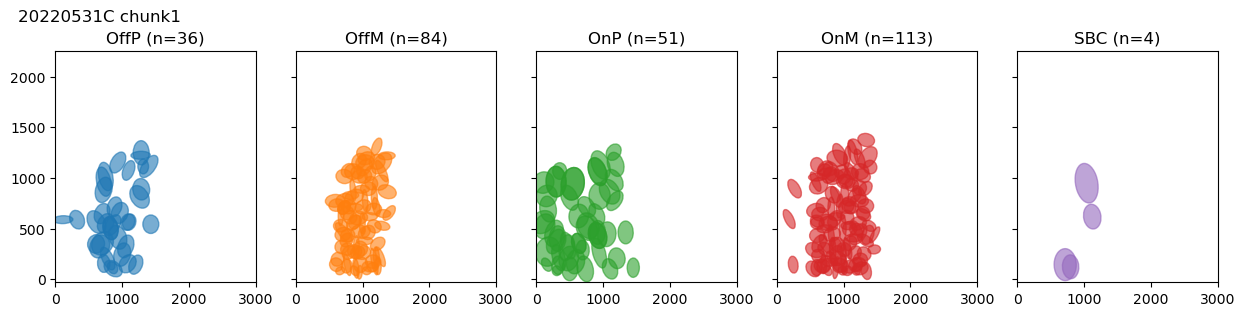

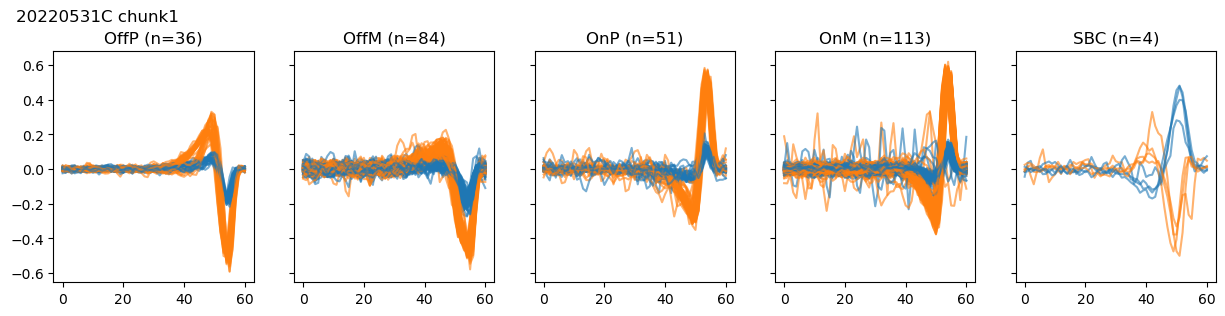

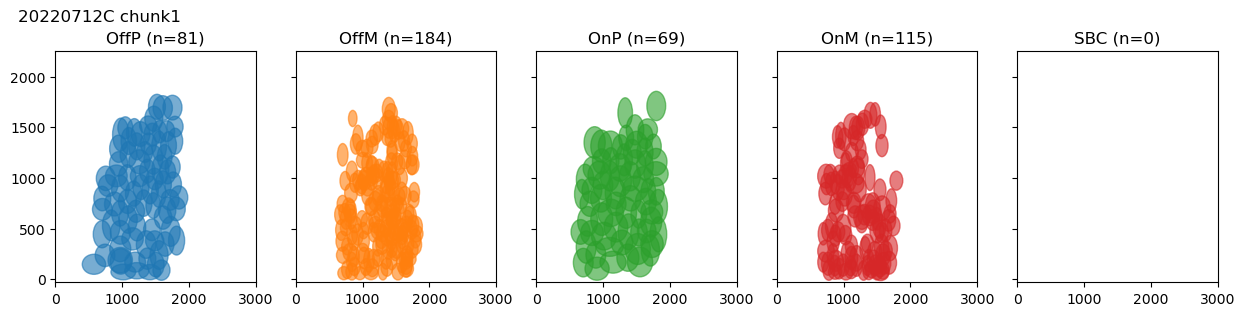

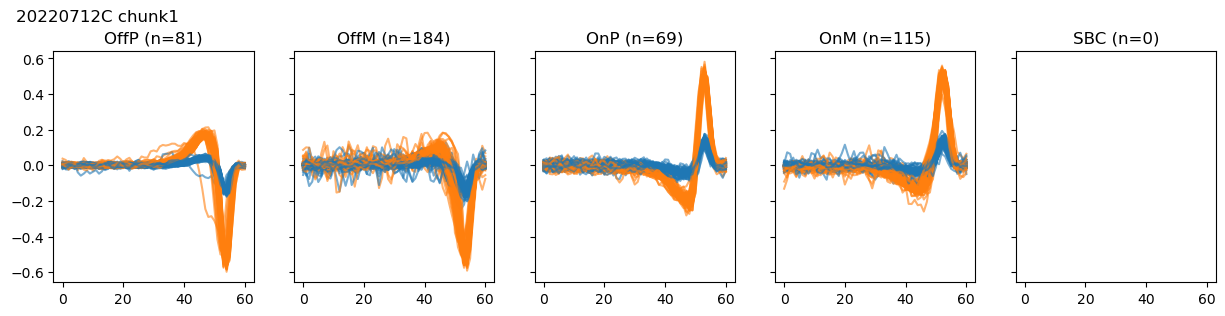

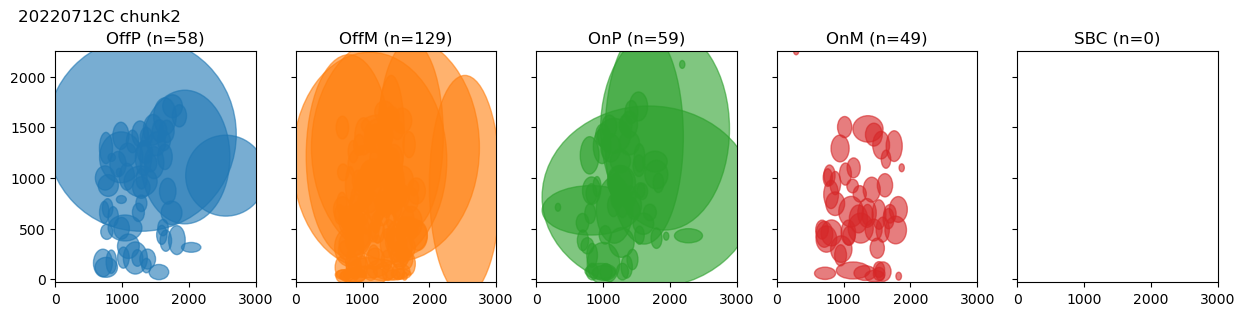

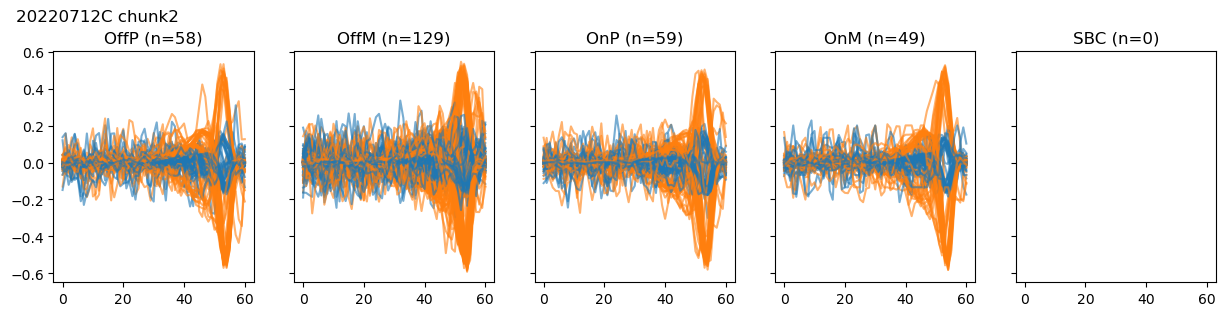

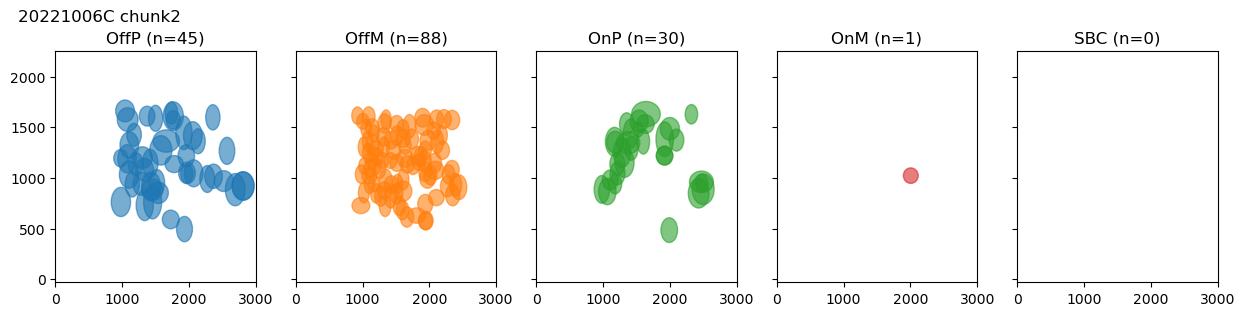

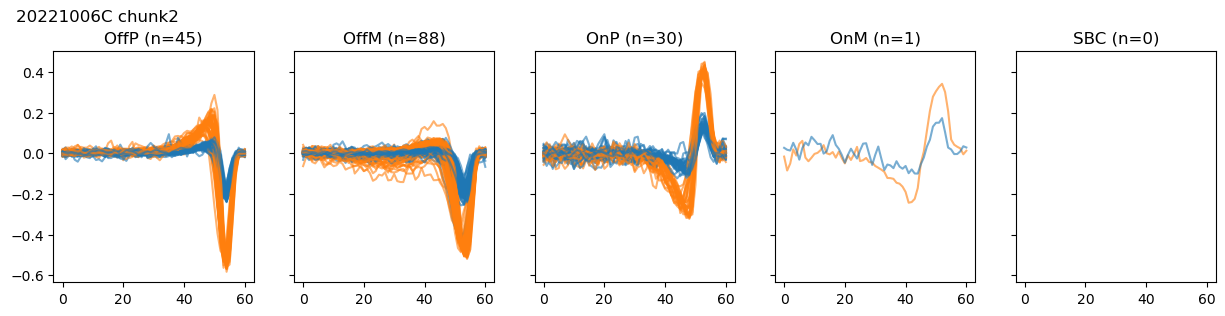

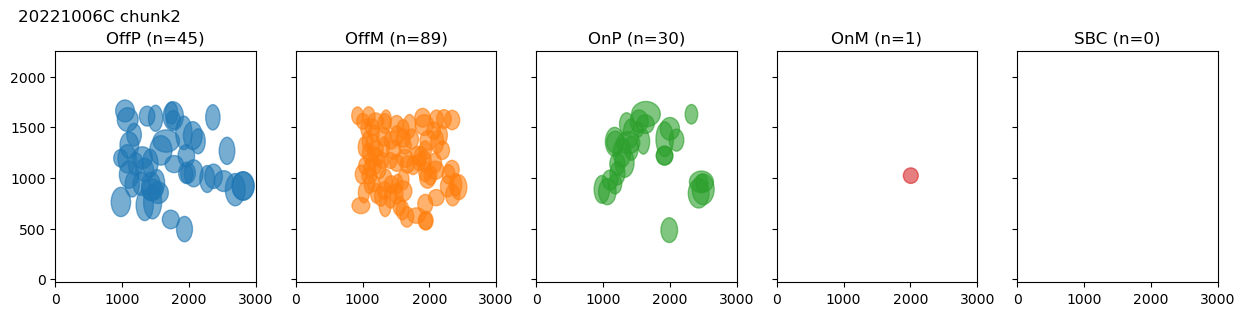

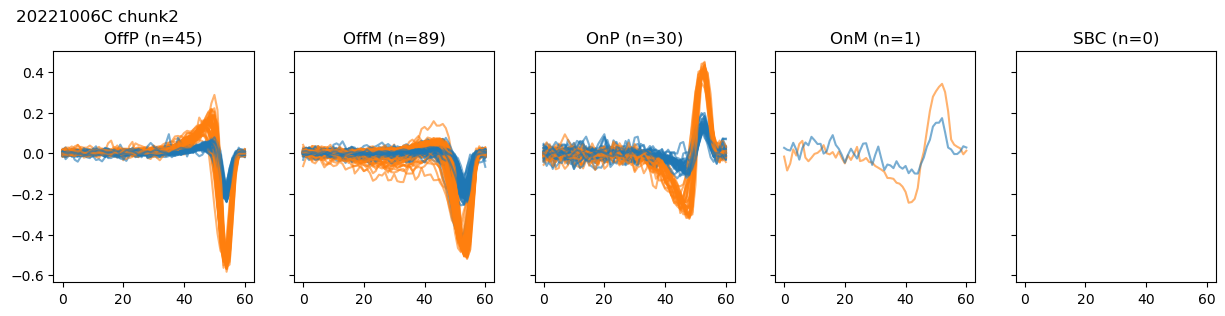

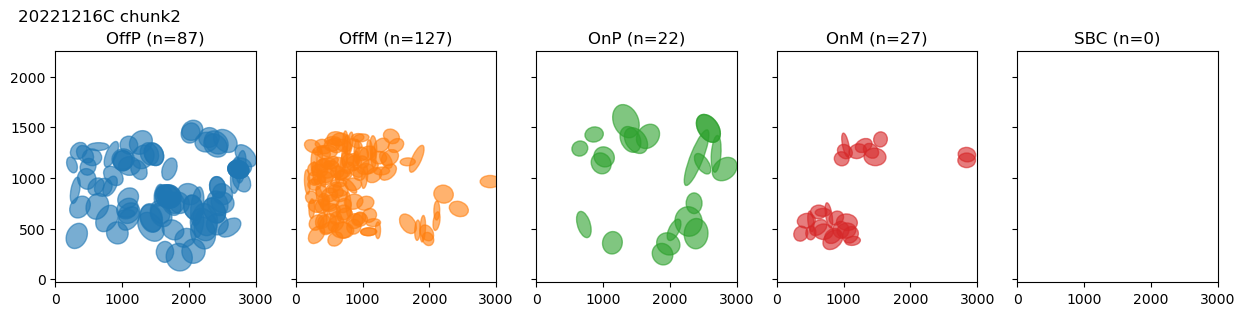

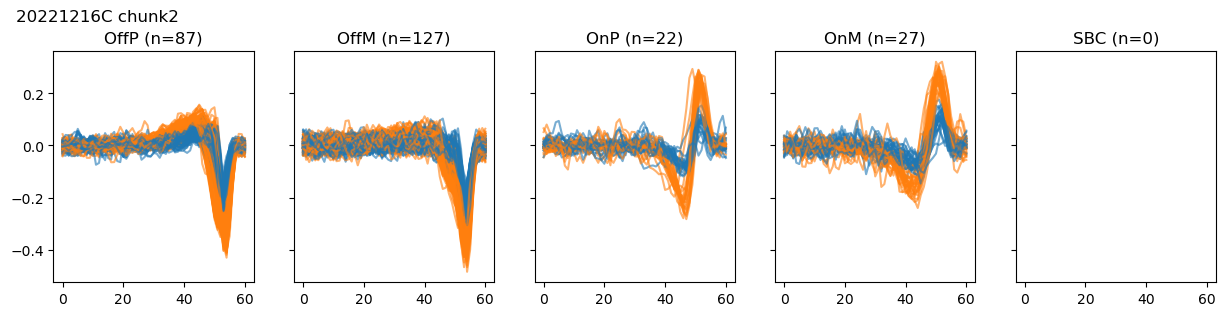

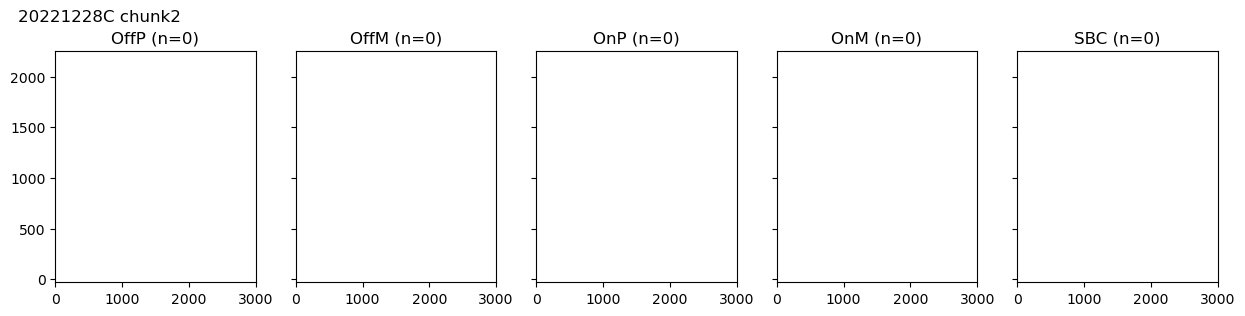

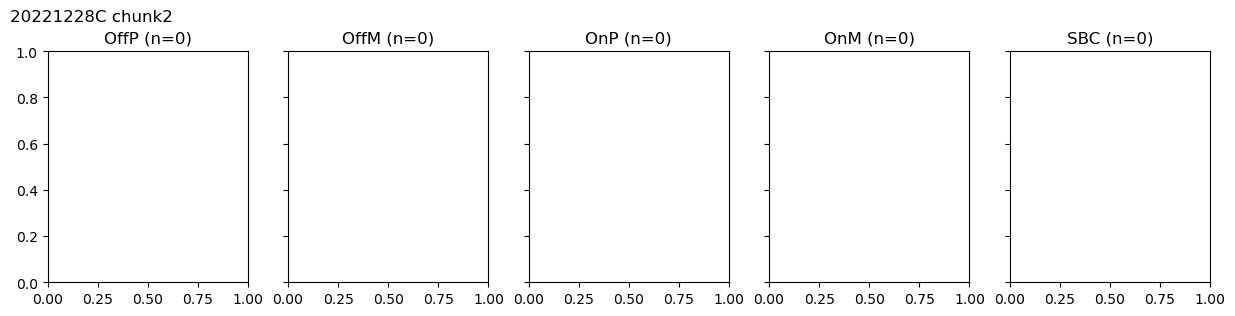

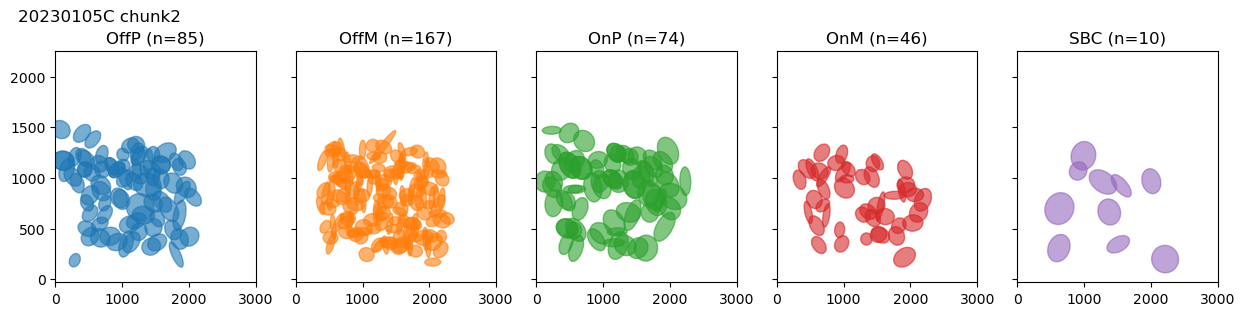

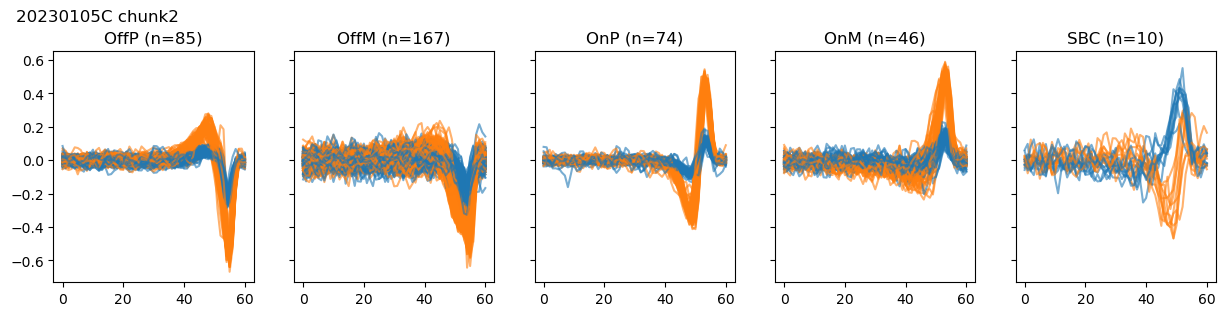

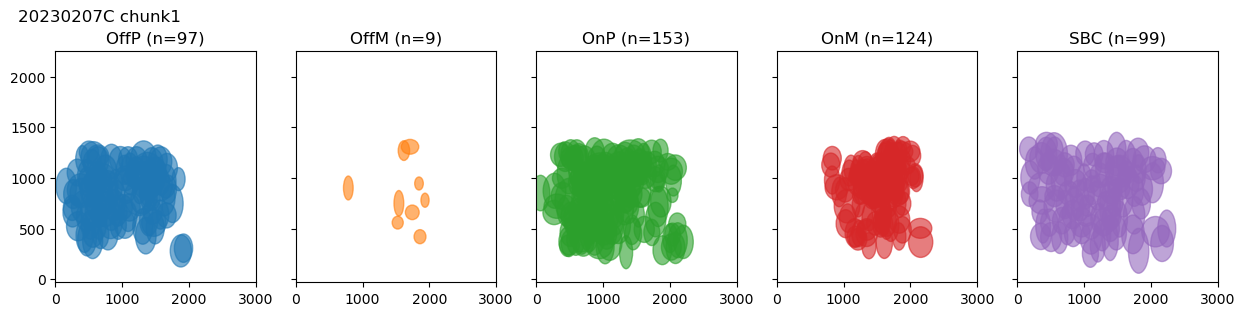

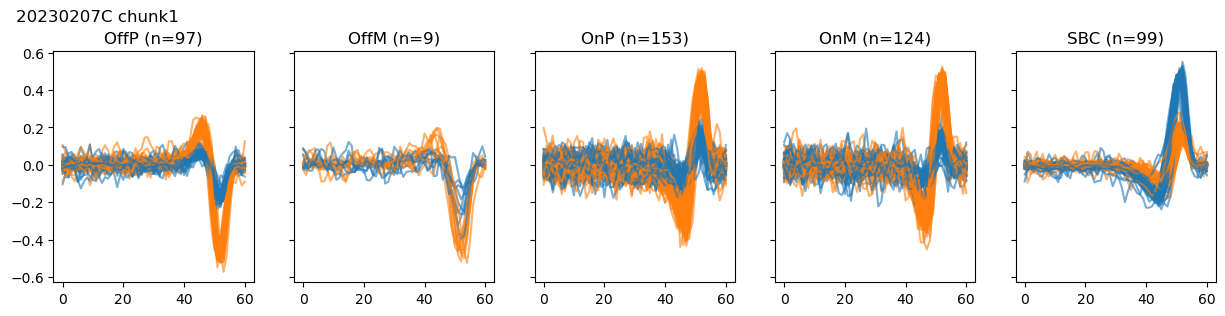

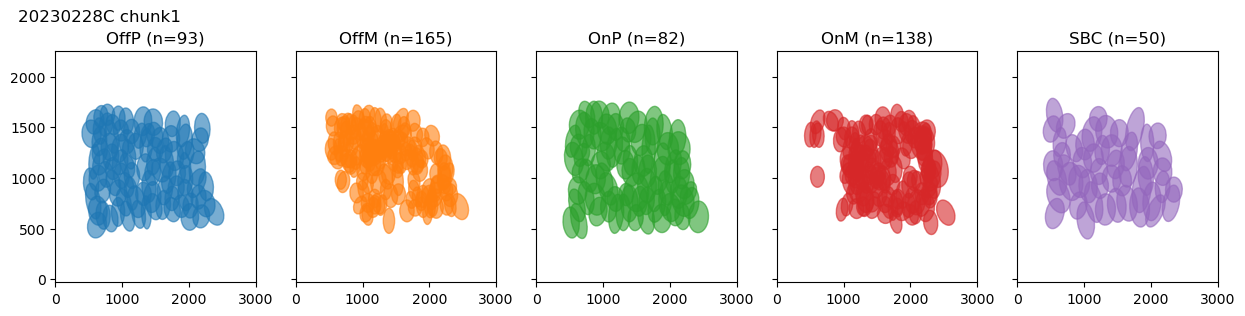

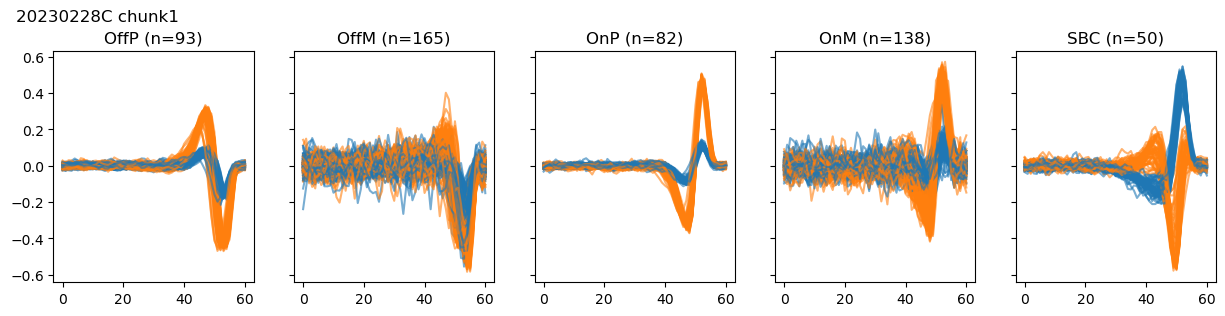

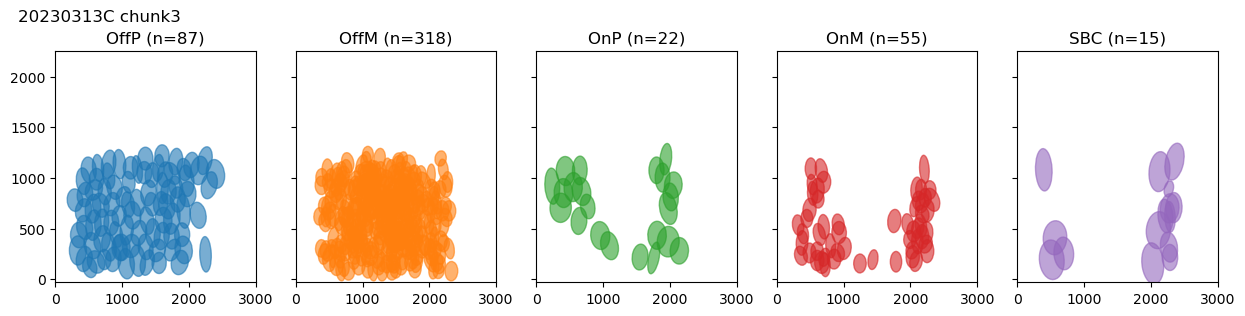

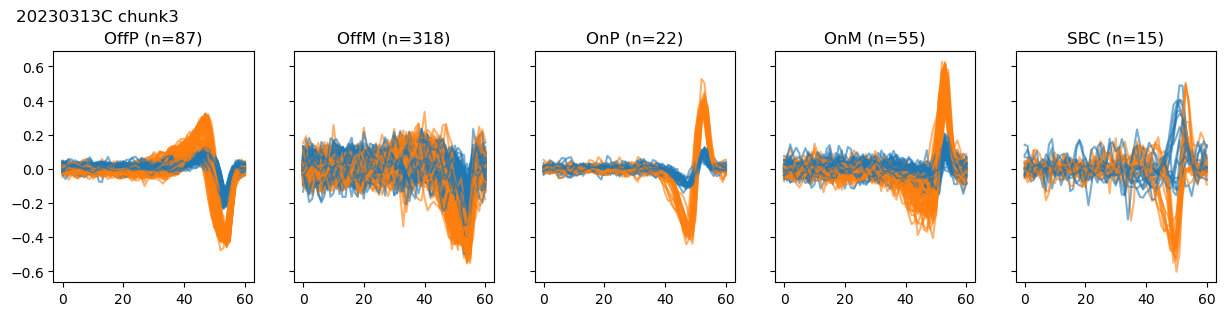

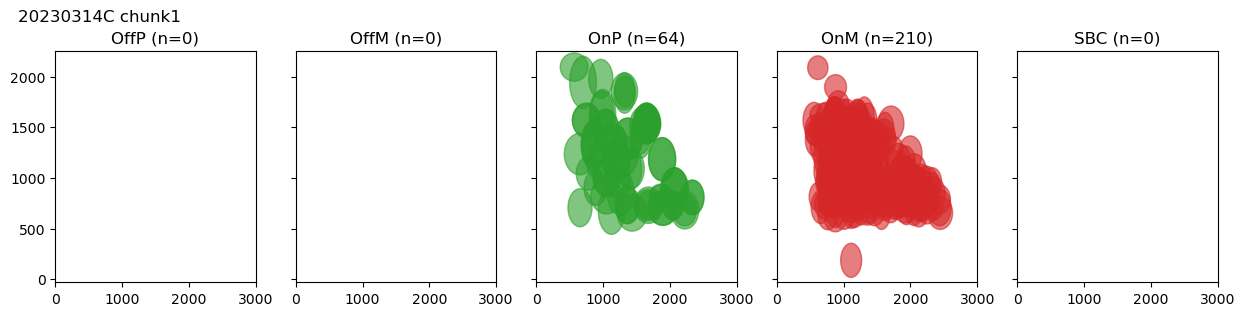

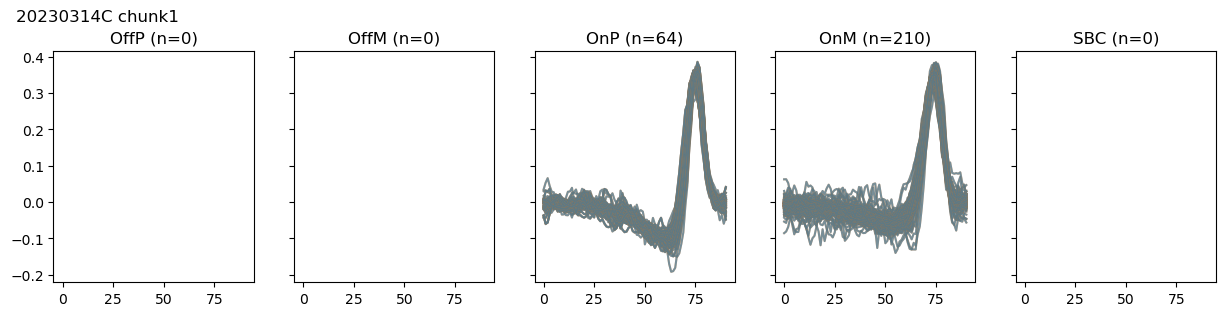

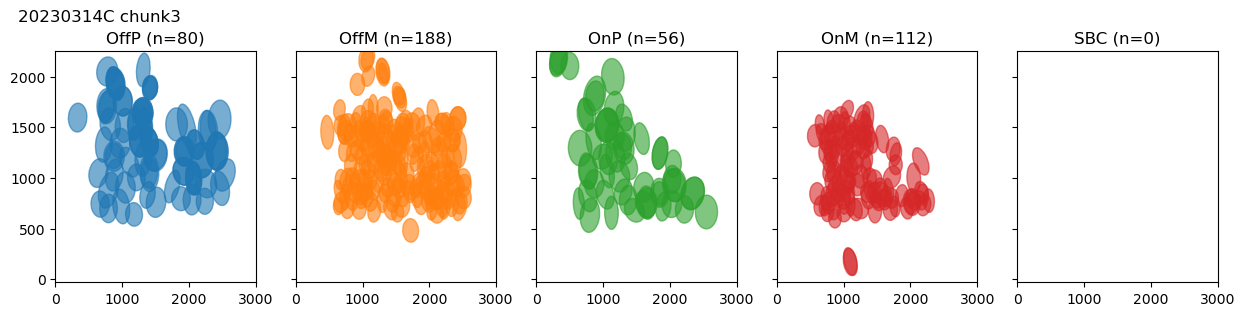

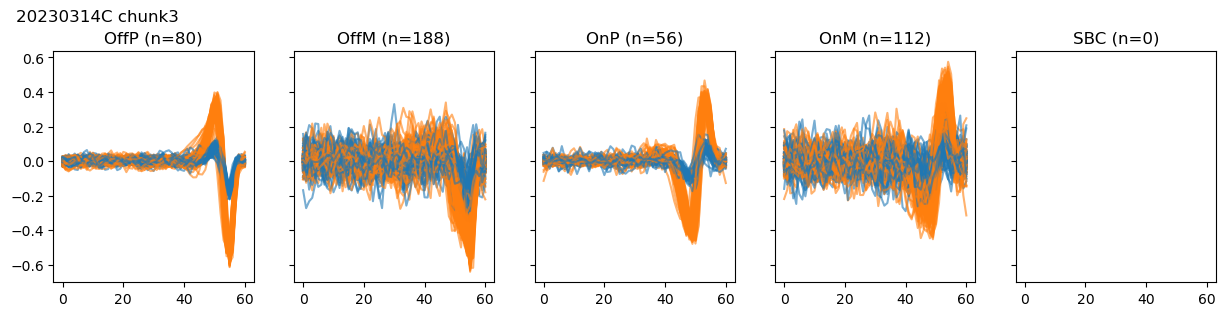

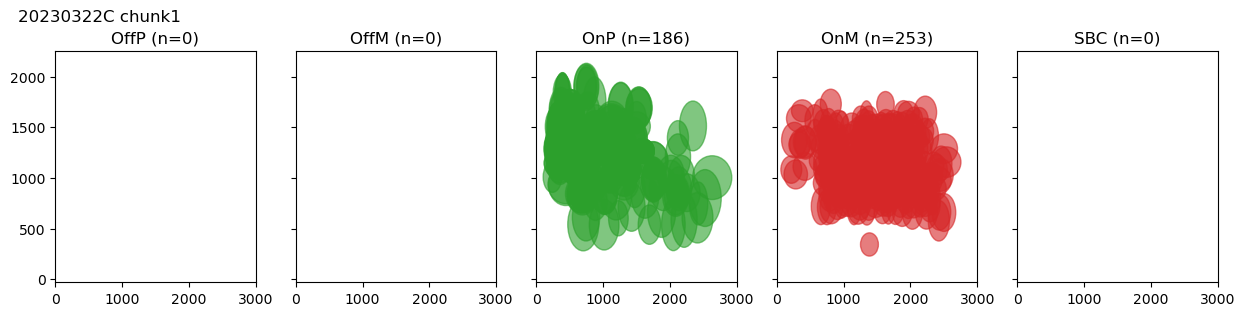

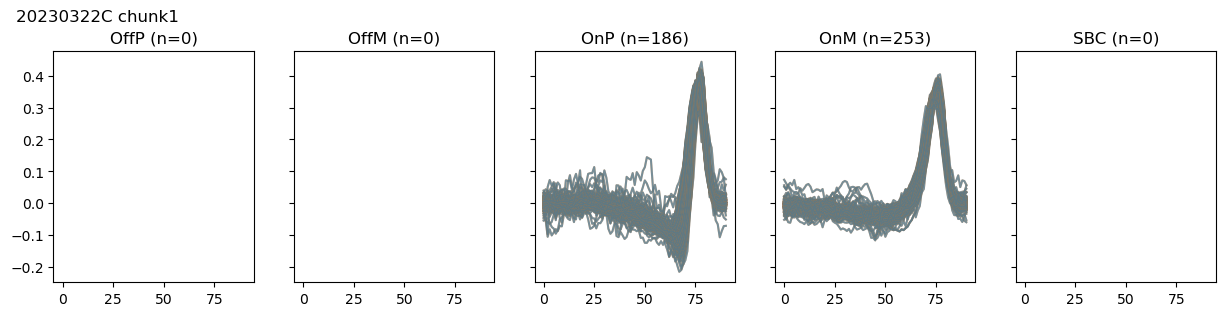

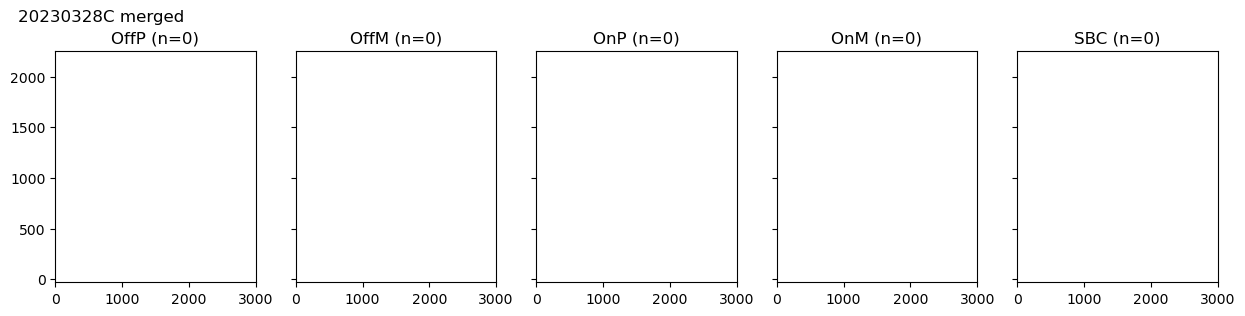

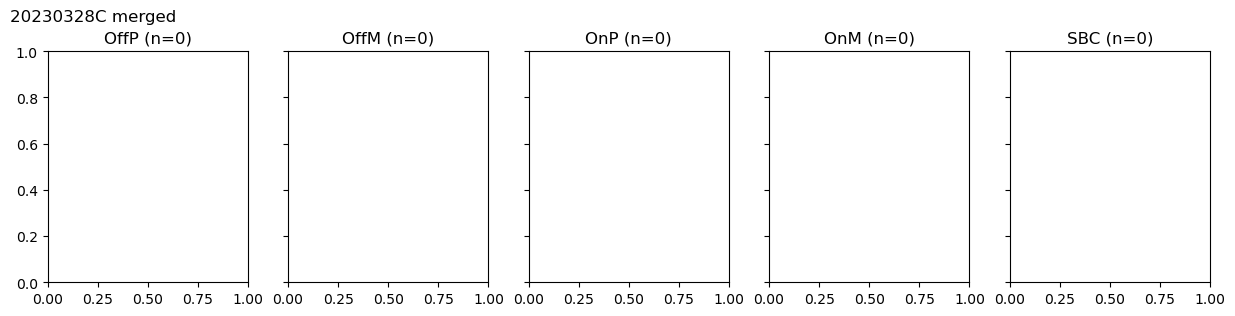

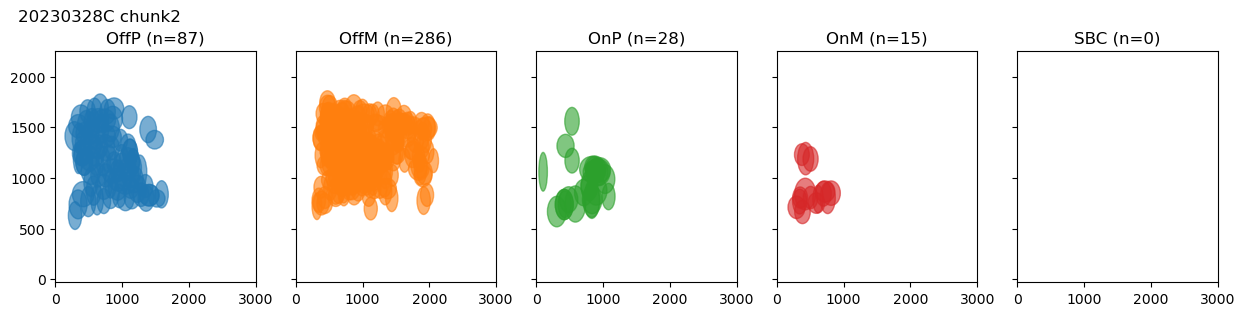

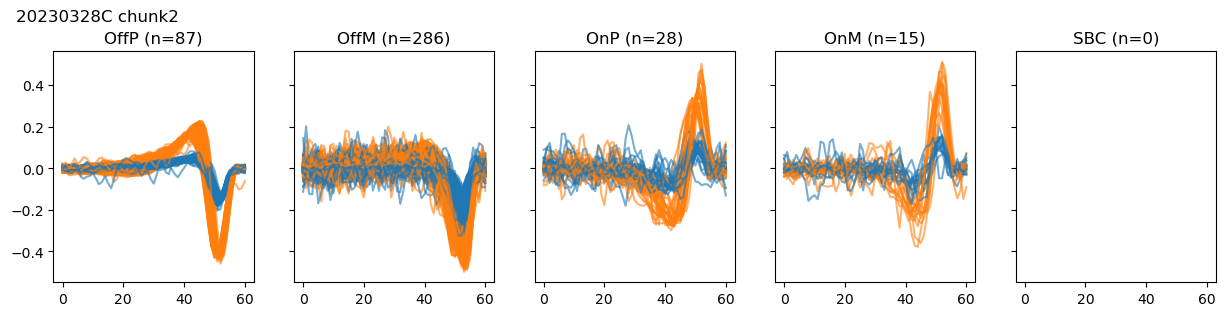

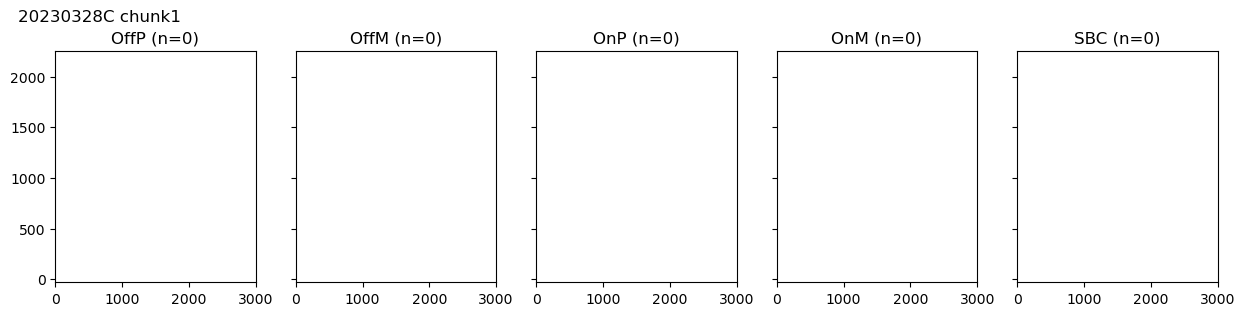

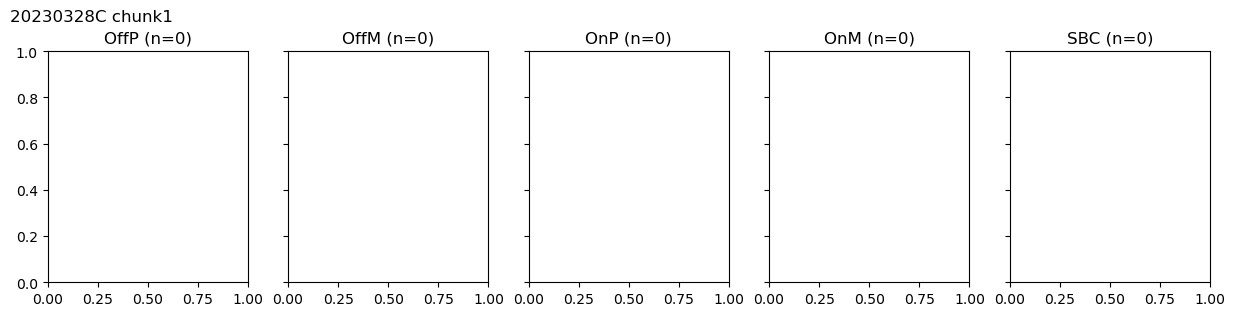

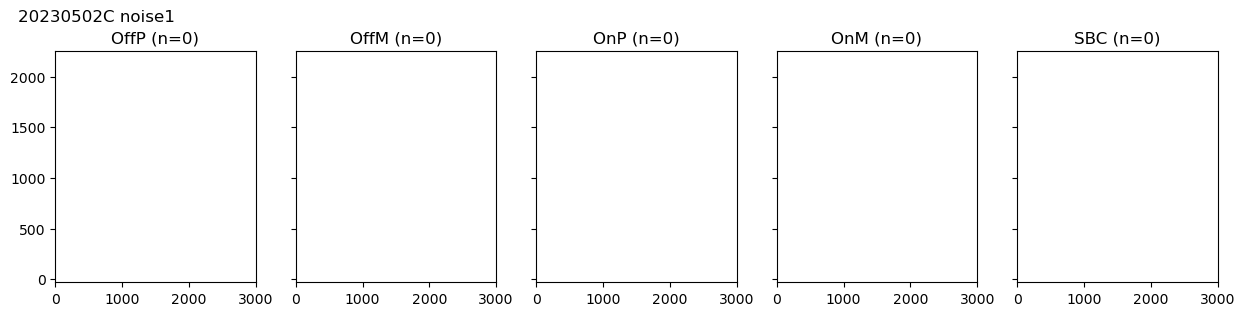

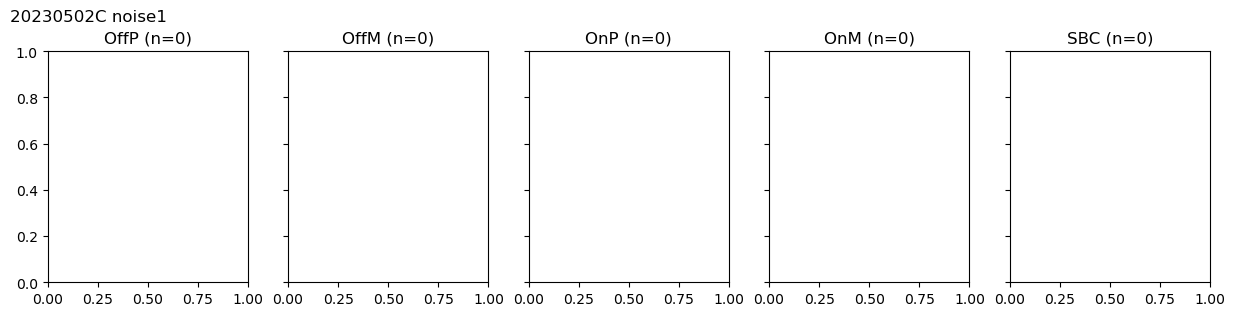

In [9]:
for str_class in ls_classifications:
    # print(str_class)
    try:
        types, data = load_data(str_class)
        plot_rfs(data, types)
        plot_tcs(data, types)
    except Exception as e:
        print(e)
        print(str_class)

In [14]:
# Get ratio of OffP to OffM cells
df_numcells = pd.DataFrame(columns=['str_experiment', 'str_chunk', 'type', 'n_cells'])
ls_append = []
for str_class in ls_classifications:
    types, data = load_data(str_class)
    if len(types.d_main_IDs['OffP'])>0:
        for str_type in ls_RGC_labels:
            ls_append.append({'str_experiment': data.str_experiment, 'str_chunk': data.str_chunk, 
                            'type': str_type, 'n_cells': len(types.d_main_IDs[str_type])})

In [16]:
df_numcells = pd.concat([df_numcells, pd.DataFrame(ls_append)])

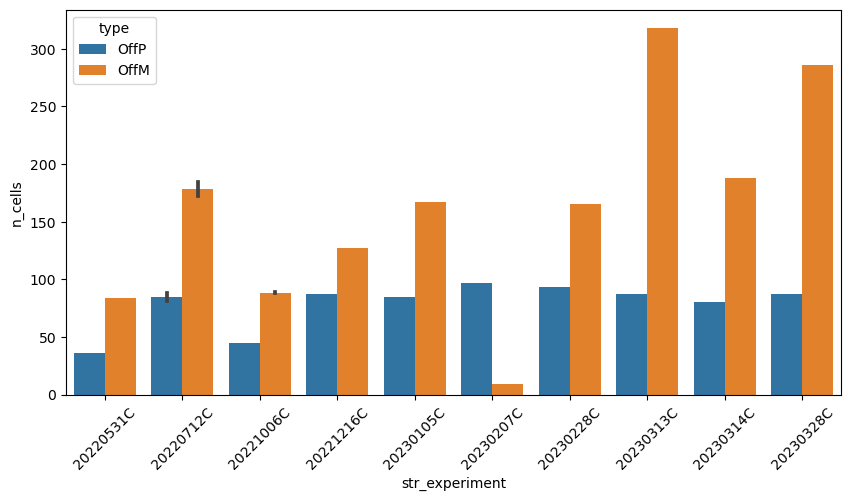

In [19]:
# Plot only OffP and OffM barplot
df_plot = df_numcells[df_numcells['type'].isin(['OffP', 'OffM'])]
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_plot, x='str_experiment', y='n_cells', hue='type', ax=ax)

# Rotate xticklabels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

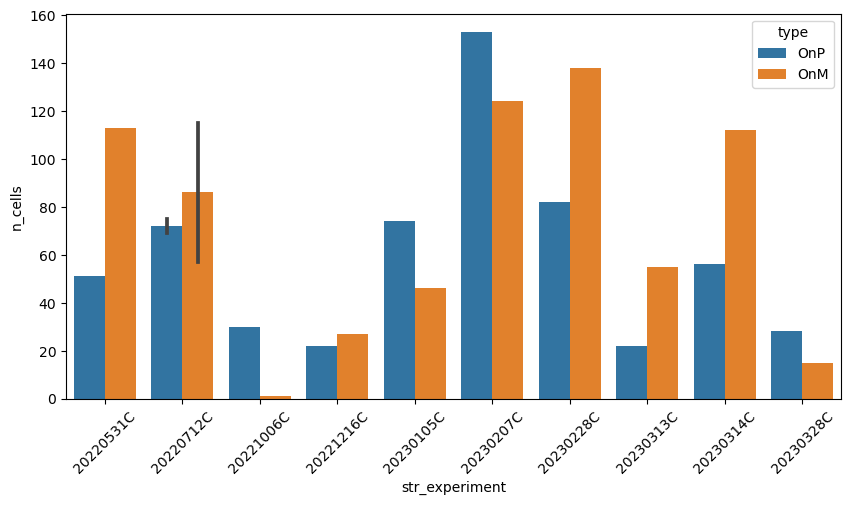

In [20]:
# Plot only OffP and OffM barplot
df_plot = df_numcells[df_numcells['type'].isin(['OnP', 'OnM'])]
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_plot, x='str_experiment', y='n_cells', hue='type', ax=ax)

# Rotate xticklabels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)